In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

rating = pd.read_csv('./ratings_drop.csv' , usecols=[ 'userId' , 'productId' , 'rating'] )
products = pd.read_csv('./products_join_categories.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.set_index( ['productId'] , inplace=True, drop=True )
products = products.rename({'name': 'product_name'}, axis='columns')
display(products.head())

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
0,CSSMs Biology: Control in Cells and in Organis...,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
1,Treasure Island,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
2,Collins Primary Dictionaries – Collins Junior ...,"832,476,739",832,图书音像,476,其它图书,739.0,工具书
3,Partners in Crime,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
4,The Hobbit,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


In [2]:
display(rating.head())

,userId,productId,rating
0,15905.0,452609,5.0
1,94522.0,452609,5.0
2,317087.0,452609,5.0
3,1329103.0,452609,5.0
4,502593.0,452609,5.0


In [3]:
display(rating.describe())

,userId,productId,rating
count,7.202839e+06,7.202921e+06,7.202920e+06
mean,3.368837e+05,2.651382e+05,4.277313e+00
std,3.619076e+05,1.525959e+05,1.060728e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.653000e+04,1.331870e+05,4.000000e+00
50%,1.915990e+05,2.667810e+05,5.000000e+00
75%,5.283595e+05,3.965950e+05,5.000000e+00
max,1.424594e+06,5.256180e+05,5.000000e+00


In [4]:
print('No. of Unique Users    :', rating.userId.nunique())
print('No. of Unique Products :', rating.productId.nunique())
print('No. of Unique Ratings  :', rating.rating.nunique())

No. of Unique Users    : 1424595
No. of Unique Products : 525619
No. of Unique Ratings  : 6


In [5]:
ratingViaUserCount = rating.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
ratingViaUserCount.columns = ['rating', 'Count']

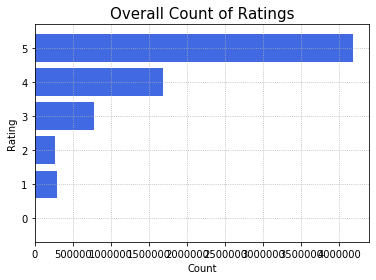

,rating,Count
0,0.0,1
1,1.0,293748
2,2.0,261960
3,3.0,781982
4,4.0,1680574


In [6]:
plt.barh(ratingViaUserCount.rating, ratingViaUserCount.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid(ls='dotted')
plt.show()
display(ratingViaUserCount.head())

In [7]:
userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 50 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 100 ].index)]
print(ratingFiltered.shape)

(1847803, 3)
(7202921, 3)
(35024, 3)


In [8]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratingFiltered[['userId', 'productId', 'rating']], reader)

In [9]:
display(products.sample(10))
display(ratingFiltered.sample(10))
display(ratingFiltered.shape)

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
352503,The Wines of Burgundy,"832,665,1048",832,图书音像,665,生活类图书,1048.0,烹饪/美食
64379,备战托业宝典(第3版)(附光盘),"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试
142792,巴赫清唱剧(DVD9 典藏版),"832,552,821",832,图书音像,552,音像,821.0,古典音乐
177367,西氏内科学(第24版):肿瘤分册,"832,1096,867",832,图书音像,1096,科技类图书,867.0,医学
112079,欧洲法律之路:欧洲法律社会学视角,"832,723,160",832,图书音像,723,人文社科类图书,160.0,法律
103417,WD 西部数据 WD Caviar Green 3.5 英寸 2TB 动态转速 64 MB ...,"1057,818,643",1057,电脑/办公,818,电脑硬件,643.0,硬盘
12924,CATIA V5R17高级设计实例教程(附赠CD光盘1张),"832,1096,43",832,图书音像,1096,科技类图书,43.0,计算机/网络
508318,泰好纯铜门锁 欧式田园风格 TH57-5205 青古铜,"571,1155,307",571,家具/家装/建材,1155,五金/工具,307.0,家具五金
211594,英汉社会学新词库,"832,1101,921",832,图书音像,1101,少儿/教育图书,921.0,外语


,userId,productId,rating
2702354,3204.0,183318,5.0
4766402,31316.0,251070,5.0
2795121,88655.0,445169,5.0
5361347,2277.0,332709,3.0
3174949,9560.0,482080,5.0
4180628,953.0,36013,1.0
3145255,23300.0,480396,4.0
124618,684.0,462476,4.0
5778500,270.0,195346,4.0
2129509,1411.0,154978,4.0


(35024, 3)

In [10]:
print('No. of Unique Users    :', ratingFiltered.userId.nunique())
print('No. of Unique Products :', ratingFiltered.productId.nunique())
print('No. of Unique Ratings  :', ratingFiltered.rating.nunique())
print(products.iloc[1].product_name)

No. of Unique Users    : 241
No. of Unique Products : 22683
No. of Unique Ratings  : 5
Treasure Island


In [11]:
productJoinEdRaiting = pd.merge(products, ratingFiltered, on='productId', how='inner')

In [12]:
display(productJoinEdRaiting.sample(10))

,productId,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name,userId,rating
18337,281109,全国勘察设计注册公用设备工程师给水排水专业执业资格考试教材:常用资料(第4册),"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试,12301.0,5.0
29383,444086,Swatch 斯沃琪石英女表-棋局人生 LB160G,"486,487,706",486,钟表/首饰/眼镜/礼品,487,钟表,706.0,手表,15596.0,3.0
18743,287472,辨证奇闻,"832,665,1011",832,图书音像,665,生活类图书,1011.0,保健/养生,7621.0,1.0
4769,71036,Kasrrow 凯仕乐 KSR-9A 升级版按摩棒 按摩锤 捶背按摩器 颈部腰部 肩部腿部 ...,"222,430,526",222,家用电器,430,保健按摩器材,526.0,其它保健器材,18727.0,5.0
28315,429034,天香,"832,519,1",832,图书音像,519,文学艺术,1.0,小说,30846.0,5.0
10884,165801,Edifier漫步者 R201T北美版 2.1声道音箱(黑色 实惠影音播放全能王),"1057,439,1064",1057,电脑/办公,439,外设产品,1064.0,电脑音箱,7811.0,5.0
13969,213000,文都教育:2012考研英语绝对考场最后五套题(附50元网校增值卡),"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试,33200.0,4.0
22974,355168,iPod touch 4代 8GB MC540CH/A 黑色 多媒体播放器,"1128,348,995",1128,手机/数码,348,数码影音,995.0,mp3/mp4,9560.0,5.0
4600,68440,再忙也要做个好妻子,"832,665,45",832,图书音像,665,生活类图书,45.0,亲子/家教,30846.0,1.0
14349,218756,Johnson强生婴儿天然舒润柔泡型滋养沐浴露400ml(特卖),"911,312,25",911,母婴/玩具,312,婴儿洗护,25.0,沐浴用品,154920.0,5.0


In [14]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    # 首先将预测值映射至每个用户
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [15]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

56597.0 [369857, 224293, 374320, 451433, 378184, 289752, 345192, 67692, 303194, 383570]
56918.0 [114037, 145678, 434976, 14335, 347091, 272072, 359965, 213289, 14103, 378596]
47.0 [224293, 177709, 251597, 239657, 174187, 453965, 139413, 314478, 145218, 349229]
24590.0 [129185, 250546, 7379, 150098, 334079, 116311, 266904, 332341, 523653, 256105]
103250.0 [455872, 456100, 463033, 303194, 308263, 309864, 310873, 232554, 45797, 47028]
5729.0 [454054, 460479, 463205, 241016, 46154, 49616, 365949, 367890, 375621, 113337]
10712.0 [368474, 108442, 23576, 224293, 479010, 522600, 213744, 378141, 474201, 364792]
79411.0 [459330, 145678, 215495, 203606, 421029, 12258, 500301, 459600, 292010, 160597]
391.0 [248555, 72532, 275707, 473113, 104398, 176634, 443797, 24137, 262607, 171075]
953.0 [232116, 517740, 240, 96214, 9321, 171571, 380640, 203606, 458464, 333574]
18235.0 [47262, 368386, 382503, 105641, 342358, 386982, 70695, 208702, 422420, 505943]
66003.0 [487555, 303194, 470839, 397986, 489542, 

In [52]:
# print(type(testset))
# print(type(testset[0]))
# dt=np.dtype('int,int,float')
# xarr = np.array(testset)
# print(xarr[:,2].max())
# print(xarr[:,2].min())
# print(xarr[:,2][0])
# xarr[:,2]
# display(testset)
temp = ratingFiltered[ratingFiltered.userId == 56597 ]
temp = temp[temp.productId == 453451]
display(temp)

,userId,productId,rating
